In [1]:
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset\\{subset}\\y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [10]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [15]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [16]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [17]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [91]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [23]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 92s 13ms/step - loss: 1.3018 - acc: 0.4395 - val_loss: 1.1254 - val_acc: 0.4662
Epoch 2/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.9666 - acc: 0.5880 - val_loss: 0.9491 - val_acc: 0.5714
Epoch 3/30
7352/7352 [==============================] - 97s 13ms/step - loss: 0.7812 - acc: 0.6408 - val_loss: 0.8286 - val_acc: 0.5850
Epoch 4/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.6941 - acc: 0.6574 - val_loss: 0.7297 - val_acc: 0.6128
Epoch 5/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.6336 - acc: 0.6912 - val_loss: 0.7359 - val_acc: 0.6787
Epoch 6/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.5859 - acc: 0.7134 - val_loss: 0.7015 - val_acc: 0.6939
Epoch 7/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.5692 - acc: 0.7477 - val_loss: 0.5995 - val_acc: 0.7387


In [24]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [27]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 2ms/step


In [28]:
score

[0.3087582236972612, 0.9097387173396675]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

## Assignment

In [19]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

### Increase the number of LSTM units

In [20]:
n_hidden = 42
drop_out_rate = 0.5
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(drop_out_rate))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
print(model.summary())

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

score = model.evaluate(X_test, Y_test)
print(f'Accuracy of model with 42 LSTM units and 0.5 dropout rate {score}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 42)                8736      
_________________________________________________________________
dropout_2 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 258       
Total params: 8,994
Trainable params: 8,994
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 54s 7ms/step - loss: 1.2644 - acc: 0.4611 - val_loss: 1.1723 - val_acc: 0.4547
Epoch 2/30
7352/7352 [==============================] - 53s 7ms/step - loss: 1.0224 - acc: 0.5407 - val_loss: 1.3362 - val_acc: 0.5453
Epoch 3/30
7352/7352 [==============================] - 51s 7ms/step - loss: 0.82

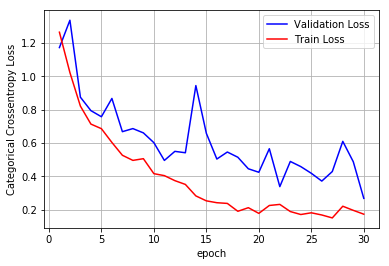

In [21]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,31))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### Decrease the number of LSTM units

In [22]:
n_hidden = 22
drop_out_rate = 0.5
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(drop_out_rate))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
print(model.summary())

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

score = model.evaluate(X_test, Y_test)
print(f'Accuracy of model with 22 LSTM units with 0.5 dropout rate {score}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 22)                2816      
_________________________________________________________________
dropout_3 (Dropout)          (None, 22)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 138       
Total params: 2,954
Trainable params: 2,954
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 45s 6ms/step - loss: 1.4248 - acc: 0.3889 - val_loss: 1.2835 - val_acc: 0.4679
Epoch 2/30
7352/7352 [==============================] - 47s 6ms/step - loss: 1.1531 - acc: 0.5192 - val_loss: 1.0650 - val_acc: 0.5202
Epoch 3/30
7352/7352 [==============================] - 47s 6ms/step - loss: 0.96

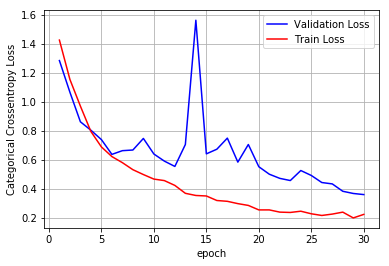

In [23]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,31))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### Increase the Drop out rate

In [24]:
n_hidden = 32
drop_out_rate = 0.8
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(drop_out_rate))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
print(model.summary())

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

score = model.evaluate(X_test, Y_test)
print(f'Accuracy of model with 32 LSTM units and 0.8 dropout rate {score}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 57s 8ms/step - loss: 1.4102 - acc: 0.4066 - val_loss: 1.2623 - val_acc: 0.4778
Epoch 2/30
7352/7352 [==============================] - 55s 8ms/step - loss: 1.2258 - acc: 0.4660 - val_loss: 1.1751 - val_acc: 0.4686
Epoch 3/30
7352/7352 [==============================] - 49s 7ms/step - loss: 1.15

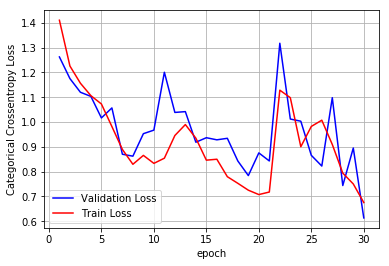

In [25]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,31))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### Decrease the Drop out rate

In [26]:
n_hidden = 32
drop_out_rate = 0.3
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(drop_out_rate))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
print(model.summary())

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

score = model.evaluate(X_test, Y_test)
print(f'Accuracy of model 32 LSTM units with 0.3 dropout rate {score}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 47s 6ms/step - loss: 1.2753 - acc: 0.4588 - val_loss: 1.0666 - val_acc: 0.5826
Epoch 2/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.8632 - acc: 0.6396 - val_loss: 0.7874 - val_acc: 0.7021
Epoch 3/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.67

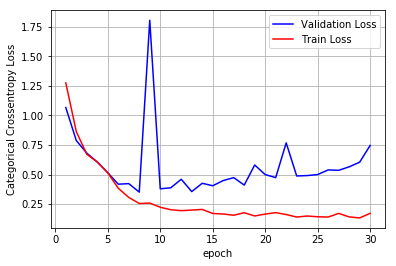

In [27]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,31))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### Two layers of LSTM with increased drop out rate

In [29]:
n_hidden = 32
drop_out_rate = 0.7
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim), return_sequences= True))
# Adding a dropout layer
model.add(Dropout(drop_out_rate))

model.add(LSTM(16))
# Adding a dropout layer
model.add(Dropout(drop_out_rate))

# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
print(model.summary())

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

score = model.evaluate(X_test, Y_test)
print(f'Accuracy of model 32 units in the first layer, 16 units in the second layer with 0.7 drop out rate {score}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 102       
Total params: 8,614
Trainable params: 8,614
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 102s 14ms/step - loss: 1.4810 -

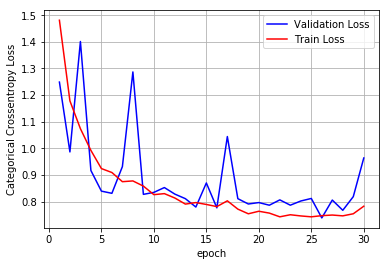

In [30]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,31))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [35]:
results_df = pd.DataFrame(columns=['No. of Layers','Number of LSTM units','Dropout rate','Overfitting','Accuracy'])

results_df['No. of Layers'] = [1, 1, 1, 1, 2]
results_df['Number of LSTM units'] = ['42','22','32','32','32,16']
results_df['Dropout rate']= ['0.5','0.5','0.8','0.3','0.7,0.7']
results_df['Overfitting'] = ['No','No','No','Yes','Yes']
results_df['Accuracy'] = [91.211,88.903,81.5088,84.6063,61.045]

# Conclusion

In [36]:
results_df

,No. of Layers,Number of LSTM units,Dropout rate,Overfitting,Accuracy
0,1,42,0.5,No,91.2110
1,1,22,0.5,No,88.9030
2,1,32,0.8,No,81.5088
3,1,32,0.3,Yes,84.6063
4,2,"32,16","0.7,0.7",Yes,61.0450


* Increase in number of LSTM units increased the accuracy
* Decrease in number of LSTM units decreased the accuracy
* Increase in Dropout rate decreased the accuracy
* Decrease in Dropout rate also decreased the accuracy due to overfitting
* Increase in the number of layers of LSTM decreased the accurancy even after increasing the dropout rate